This notebook reads in a selected region of SLCs, creates interferograms with them, and outputs the igram as an ISCE-readable file for using with SNAPHU. 


This notebook:
1. Reads in two SLCs to plot one and define a subregion to extract for full resolution unwrapping with SNAPHU
2. Reads in just the subregion
3. Creates an interferogram with it
4. Plots it once just to make sure (comment this out later)
5. Saves the subregion+full res igram as an ISCE-readable file.

This notebook was written on 10-10-22

***

Import the things we need.

In [1]:
import os,sys
import glob
import pandas as pd
import math
from osgeo import gdal
import numpy as np
from array import array
from scipy  import signal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter

import isce
import isceobj
from contrib.Snaphu.Snaphu import Snaphu

import shutil
from imageMath import IML

%matplotlib  widget

Using default ISCE Path: /home/rlohman/Software/isce-2.2.0/isce


Set the working directory and define dimensions of the SLC files we'll be loading in

In [2]:
workdir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'
outputdir = '/data/ocp4/LagunaSalada/8_unwrap/test_unwrap_20211215-20211221/'
outputdir = '/data/ocp4/LagunaSalada/8_unwrap/test_unwrap_20190921-20190927/'

# size of full res SLCs
dxIN=18000
dyIN=3600

Load in the dates of the SLCs for loading them.

In [3]:
# load in dates
dates = [os.path.basename(x) for x in glob.glob(workdir+"SLC_vv/2*")]
dates = sorted(dates)
nd = len(dates)

Read in 2 SLCs for choosing the small region to extract for full res unwrapping with SNAPHU.

In [4]:
# define the dates. 
date1='20190921'
date2='20190927'

In [5]:
# Read in 2 full SLCs to make interferogram 
ds = gdal.Open(workdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(0,0,dxIN,dyIN)
print('SLC 1 loaded.')
ds = gdal.Open(workdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(0,0,dxIN,dyIN)
print('SLC 2 loaded.')

SLC 1 loaded.
SLC 2 loaded.


Try a bounding box, plot it with the next cell, then can edit the box. 

In [6]:
# make a bounding box to figure out the region to extract 
box = np.zeros((5,2))
x1 = 17000; x2 = 14000
y1 = 1750;  y2 = 1000
box[0] = [x1,y1]; box[1] = [x2,y1]
box[2] = [x2,y2]; box[3] = [x1,y2]
box[4] = box[0]

Plot the SLC magnitudes and the bounding box to choose a region to extract.

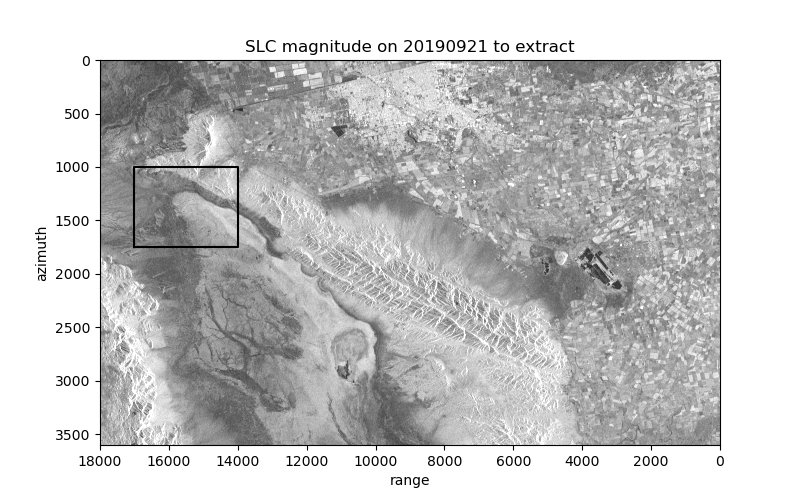

In [7]:
my_vmin = 1
my_vmax = 2.2

plt.figure(figsize=(8,5))
plt.imshow(np.log10(np.abs(slc1)), vmin=my_vmin, vmax=my_vmax, cmap='gray', aspect='auto')
plt.plot(box[:,0],box[:,1],'k-')
plt.xlim(np.shape(slc1)[1], 0)
plt.xlabel('range')
plt.ylabel('azimuth')
plt.title('SLC magnitude on '+str(date1)+' to extract')
plt.show()

Set the output dimensions of the files we will write, based on the box defined above. 

In [8]:
dxOUT = int(np.abs(x1-x2))
dyOUT = int(np.abs(y1-y2))

print('range: '+str(dxOUT))
print('azimuth: '+str(dyOUT))
print('total number of pixels: '+str(dxOUT*dyOUT))

range: 3000
azimuth: 750
total number of pixels: 2250000


In [9]:
alooks=4
rlooks=20

In [38]:
# read in two SLCs (loop through them later), make igram, output it as a file

# set the driver first, only do once. IS THIS RIGHT?
driver=gdal.GetDriverByName('ISCE')


ds = gdal.Open(workdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dxOUT,dyOUT)
print('SLC 1 subsect loaded.')
ds = gdal.Open(workdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dxOUT,dyOUT)
print('SLC 2 subsect loaded.')
intTemp = (slc1*np.conj(slc2))
# save the file 
colds = driver.Create(outputdir+'igram_temp.r4',dxOUT,dyOUT,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(np.angle(intTemp))
colds=None

# filter the igram here.  
s1=slc1*np.conj(slc1)
s2=slc2*np.conj(slc2)
a1r=gaussian_filter(np.real(s1), sigma=[alooks/4,rlooks/4])
a1i=gaussian_filter(np.imag(s1), sigma=[alooks/4,rlooks/4])
a2r=gaussian_filter(np.real(s2), sigma=[alooks/4,rlooks/4])
a2i=gaussian_filter(np.imag(s2), sigma=[alooks/4,rlooks/4])
a1 = a1r+1j*a1i
a2 = a2r+1j*a2i
filtimager=gaussian_filter(np.real(intTemp), sigma=[alooks/4,rlooks/4])
filtimagei=gaussian_filter(np.imag(intTemp), sigma=[alooks/4,rlooks/4])
filt_intTemp = filtimager+1j*filtimagei
scaler    = np.sqrt(a1*a2)
filt_intTemp = filt_intTemp/scaler

# save the file 
colds = driver.Create(outputdir+'filt_igram_temp.r4',dxOUT,dyOUT,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(np.angle(filt_intTemp))
colds=None

print('igram and filt igram saved.')

SLC 1 subsect loaded.
SLC 2 subsect loaded.
igram and filt igram saved.


In [43]:
# unwrap both versions of the interferogram

# output a string SNAPHU output (unwrapped) file to be named. 
#outfile = outputdir+date1+'_'+date2+'_filt_unwr.int'
outfile = outputdir+'unwrapped_igram_temp.r4'
#outfile = outputdir+'filt_unwrapped_igram_temp.r4'

inputFilename = outputdir+'igram_temp.r4'
#inputFilename = outputdir+'filt_igram_temp.r4'

# try using SNAPHU in the loop
#! start_isce
#! python /data/ocp4/LagunaSalada/testSnaphu.py '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/igramTemp.r4' outfile
#inputFilename = sys.argv[1]
#outputFilename = sys.argv[2]
snaphu = Snaphu()
snaphu.setInput(inputFilename)
snaphu.setOutput(outfile)
snaphu.setWidth(3000) # this was 4800 for Rowena's test 
snaphu.setCostMode('DEFO') # try SMOOTH, was DEFO to start
snaphu.setEarthRadius(6356236.24233467)
snaphu.setWavelength(0.0562356424)
snaphu.setAltitude(788151.7928135)
snaphu.setCorFileFormat('FLOAT_DATA')
snaphu.setIntFileFormat('FLOAT_DATA')
snaphu.setUnwFileFormat('FLOAT_DATA')

print("Preparing")
snaphu.prepare()
snaphu.unwrap()

copyThisFile = outputdir+'igram_temp.r4.xml'
putItHere = outputdir+'unwrapped_igram_temp.r4.xml'
#putItHere = outputdir+'filt_unwrapped_igram_temp.r4.xml'

# copy the file
shutil.copy(copyThisFile,putItHere)

#infile = outputdir+date1+'_'+date2+'_filt_unwr.int'
infile = outputdir+'unwrapped_igram_temp.r4.xml'
#infile = outputdir+'filt_unwrapped_igram_temp.r4.xml'



#img, dataname, metaName = IML.loadImage(inps.infile) # original line
img, dataname, metaName = IML.loadImage(infile)

# ^ that part isn't working. Was it necessary? I think it still unwrapped ok but the next code cell can't read it in properly. 



#img.filename = fname # original line of code 
img.filename = putItHere
img.setAccessMode('READ')
img.renderHdr()
# for some reason this makes an extra .xml.xml and .xml.vrt files that are unecessary, remove them 
os.remove(putItHere+'.xml')
os.remove(putItHere+'.vrt')

Preparing

snaphu v1.4.2
Reading wrapped phase from file /data/ocp4/LagunaSalada/8_unwrap/test_unwrap_20190921-20190927/igram_temp.r4
No weight file specified.  Assuming uniform weights
No correlation file specified.  Assuming correlation = 0.01
Calculating deformation-mode cost parameters
Initializing flows with MST algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 28
Flow increment: 1  (Total improvements: 0)
Growing connected component mask
Writing connected components to file /data/ocp4/LagunaSalada/8_unwrap/test_unwrap_20190921-20190927/unwrapped_igram_temp.r4.conncomp
Maximum flow on network: 1
Total solution cost: 28454237
Integrating phase
Writing output to file /data/ocp4/LagunaSalada/8_unwrap/test_unwrap_20190921-20190927/unwrapped_igram_temp.r4


RuntimeError: dictionary keys changed during iteration

Read in the files I just saved above and plot them to make sure I extracted the right thing. 

In [10]:
# Now that I've tested one, load in the file and plot it. 
f1 = gdal.Open(outputdir+'igram_temp.r4', gdal.GA_ReadOnly)
igram = f1.ReadAsArray()
f1 = None
f1 = gdal.Open(outputdir+'filt_igram_temp.r4', gdal.GA_ReadOnly)
filt_igram = f1.ReadAsArray()
f1 = None


# these aren't opening b/c of the issue earlier.
f1 = gdal.Open(outputdir+'unwrapped_igram_temp.r4', gdal.GA_ReadOnly)
unwr_igram = f1.ReadAsArray()
f1 = None
f1 = gdal.Open(outputdir+'filt_unwrapped_igram_temp.r4', gdal.GA_ReadOnly)
unwr_filt_igram = f1.ReadAsArray()
f1 = None

In [11]:
# try re-wrapping the unwrapped versions. Like Rowena does in mdx.
rewrapped_igram = np.angle(np.exp(1j*unwr_igram))
rewrapped_filt_igram = np.angle(np.exp(1j*unwr_filt_igram))

In [41]:
a = 3.4 + 4.4*1j
b = 1.2 + 2.2*1j

c = np.angle(a)-np.angle(b)
d = np.angle(a*np.conj(b))

print(c)
print(d)

-0.15854188350207998
-0.15854188350207996


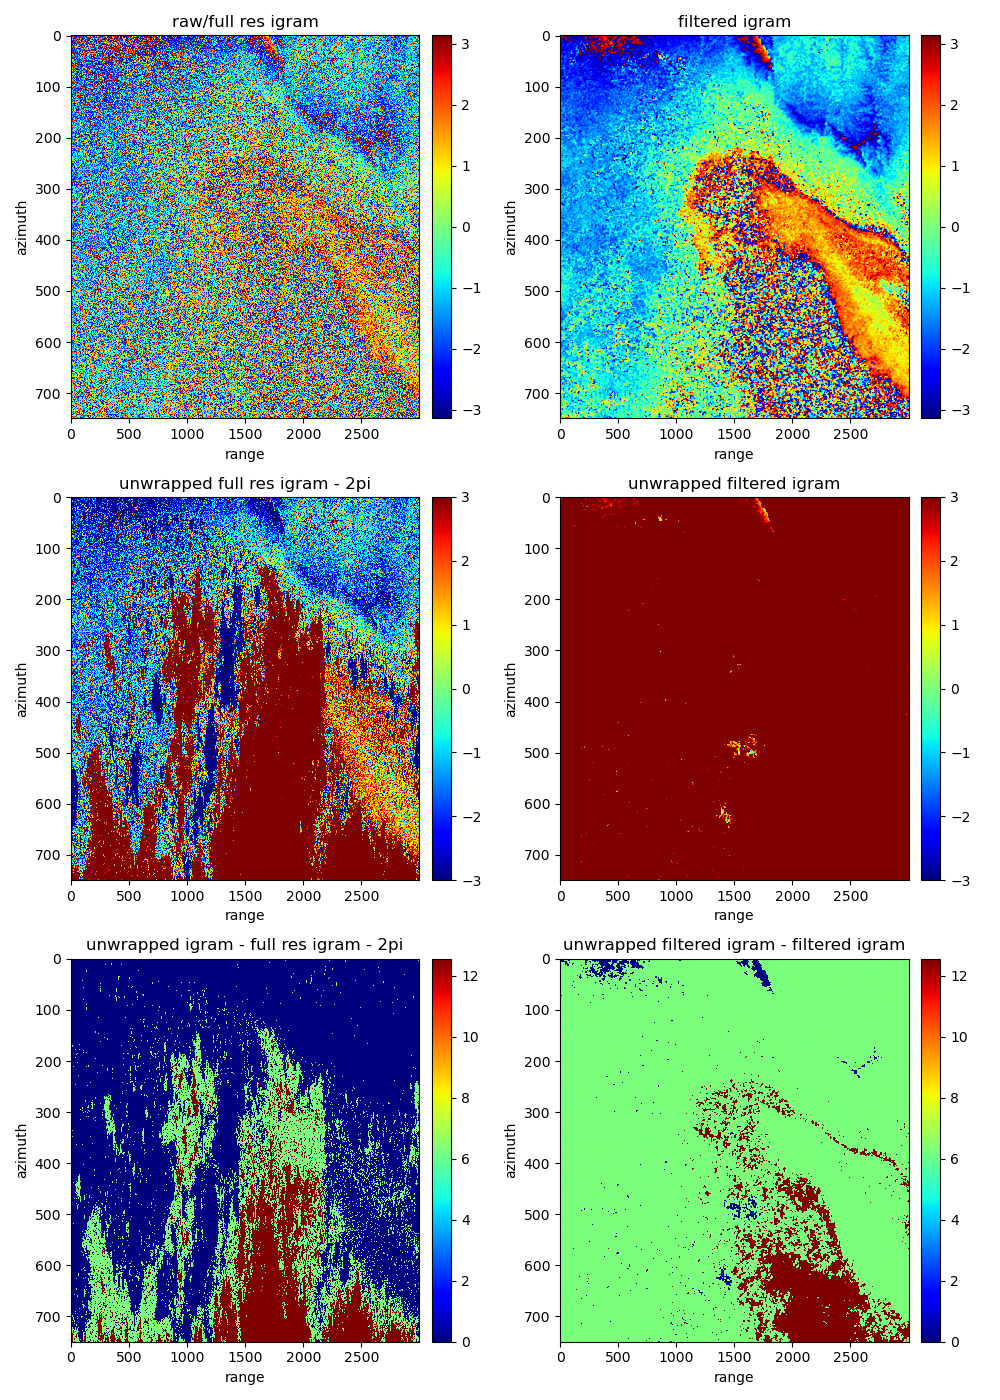

In [12]:
# now plot all versions
fig = plt.figure(figsize=(10,14),tight_layout='TRUE')
plt.subplot(3,2,1)
plt.imshow(np.fliplr(igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('raw/full res igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(3,2,2)
plt.imshow(np.fliplr(filt_igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('filtered igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(3,2,3)
plt.imshow(np.fliplr(unwr_igram-2*np.pi),aspect='auto',interpolation='nearest',vmin=-3,vmax=3)
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('unwrapped full res igram - 2pi'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(3,2,4)
plt.imshow(np.fliplr(unwr_filt_igram),aspect='auto',interpolation='nearest',vmin=-3,vmax=3)
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('unwrapped filtered igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(3,2,5)
plt.imshow(np.fliplr(unwr_igram-igram-2*np.pi),aspect='auto',interpolation='nearest',vmin=0,vmax=4*np.pi)
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('unwrapped igram - full res igram - 2pi'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(3,2,6)
plt.imshow(np.fliplr(unwr_filt_igram-filt_igram),aspect='auto',interpolation='nearest',vmin=0,vmax=4*np.pi)
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('unwrapped filtered igram - filtered igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.show()

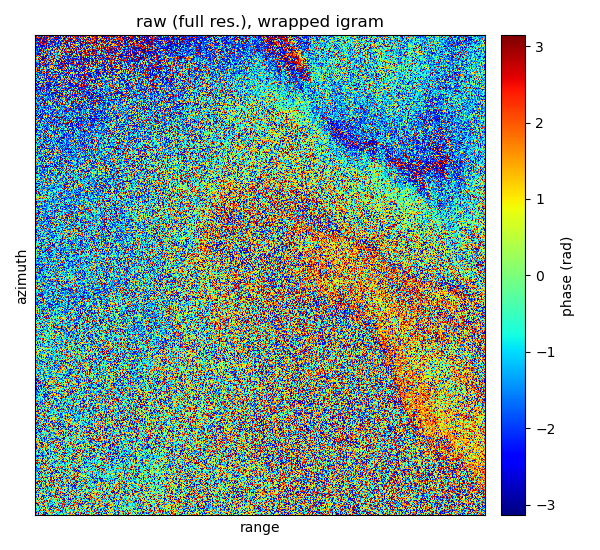

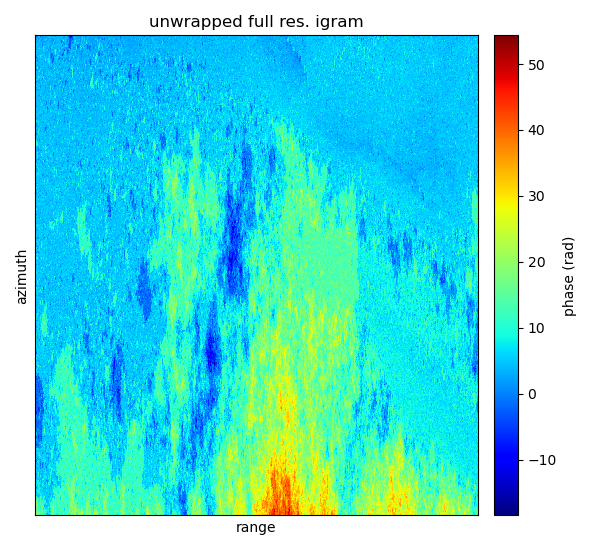

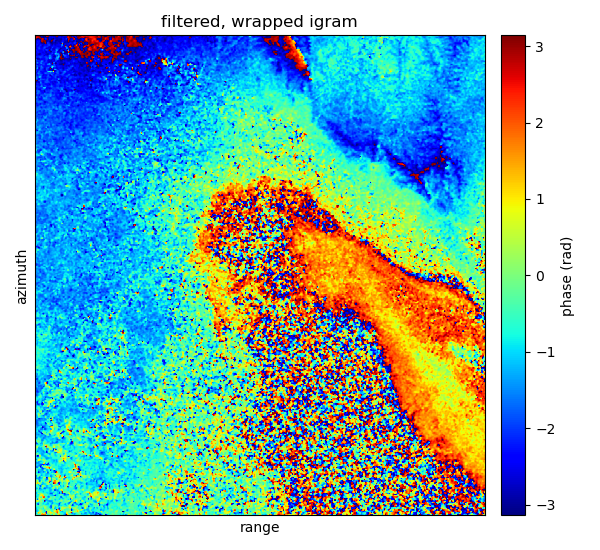

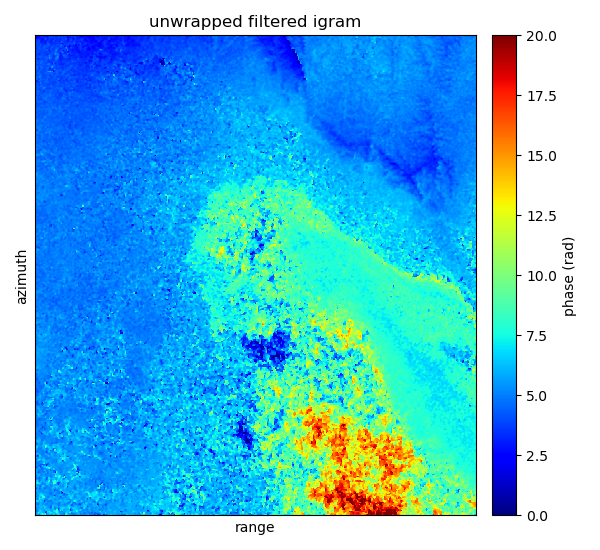

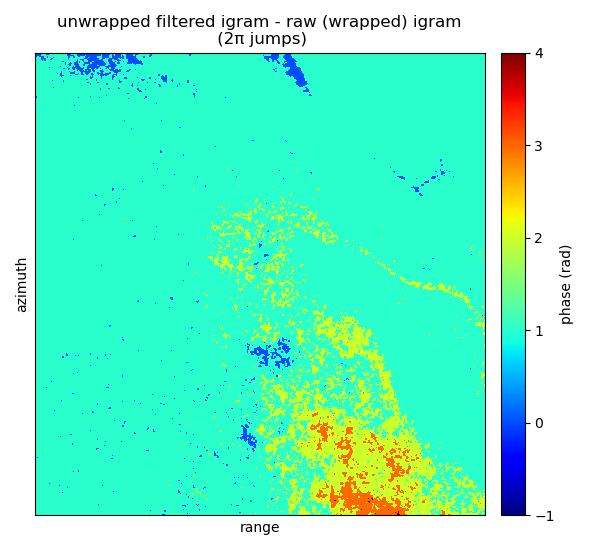

In [15]:
# Plots for Geol.Sci.Seminar on March 17, 2023. Showing how I did full resolution unwrapping. 

plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(np.fliplr(igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.title('raw (full res.), wrapped igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.show()

plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(np.fliplr(unwr_igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.title('unwrapped full res. igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.show()

plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(np.fliplr(filt_igram),aspect='auto',interpolation='nearest',vmin=-np.pi,vmax=np.pi)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.title('filtered, wrapped igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.show()

plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(np.fliplr(unwr_filt_igram),aspect='auto',interpolation='nearest',vmin=0,vmax=20)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.title('unwrapped filtered igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.show()

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


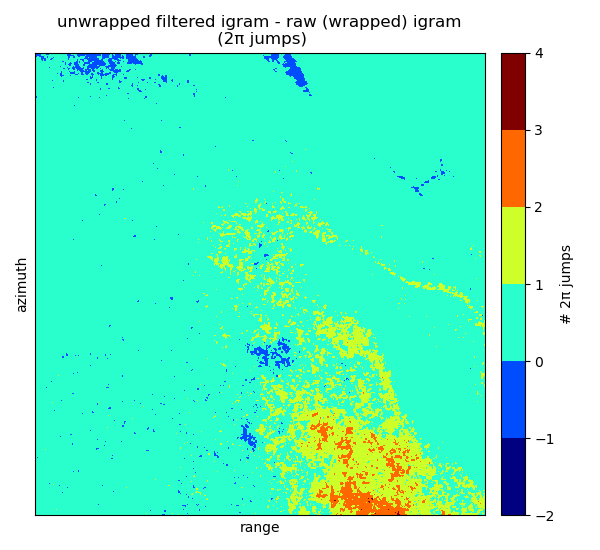

In [35]:
two_pi_jumps = (unwr_filt_igram-filt_igram)/(2*np.pi)
print(np.round(two_pi_jumps))
import matplotlib as mpl
cmap = mpl.cm.jet  # define the colormap
bounds=[-2,-1,0,1,2,3,4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N) #, extend='both'
plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(np.fliplr(np.round(two_pi_jumps)),aspect='auto',interpolation='nearest')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),orientation='vertical',pad=0.03,label='# 2\u03C0 jumps'); 
plt.title('unwrapped filtered igram - raw (wrapped) igram\n (2\u03C0 jumps)'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.show()

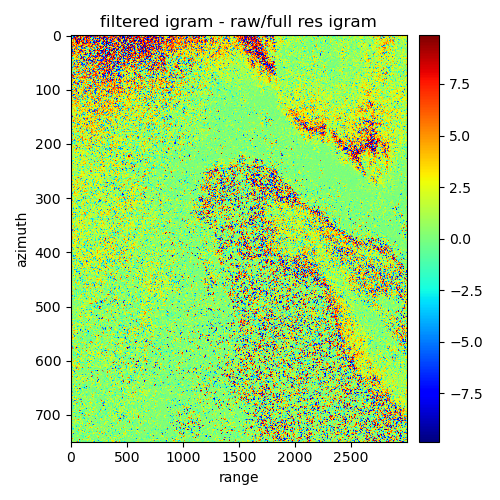

In [49]:
fig = plt.figure(figsize=(5,5),tight_layout='TRUE')
plt.imshow(np.fliplr((filt_igram)*np.conj(igram)),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('filtered igram - raw/full res igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.show()

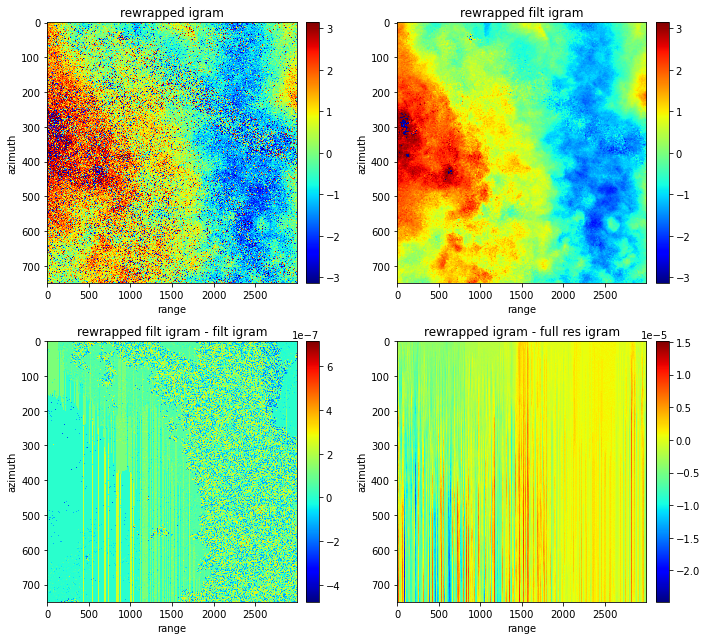

In [ ]:
# now plot all versions
fig = plt.figure(figsize=(10,9),tight_layout='TRUE')
plt.subplot(2,2,1)
plt.imshow(np.fliplr(rewrapped_igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('rewrapped igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(2,2,2)
plt.imshow(np.fliplr(rewrapped_filt_igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('rewrapped filt igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(2,2,3)
plt.imshow(np.fliplr(rewrapped_filt_igram-filt_igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('rewrapped filt igram - filt igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(2,2,4)
plt.imshow(np.fliplr(rewrapped_igram-igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('rewrapped igram - full res igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.show()

Looks good! 